In [13]:
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


In [212]:
#  Input -> encoder -> gaussian (mean, std.dev) -> decoder -> reconstruction

class VAE(nn.Module):
    def __init__(self, in_shape,hidden_size, latent_size ):
        super(VAE, self).__init__()

        self.nin = np.prod(in_shape)
        self.latent_size = latent_size
        self.hidden_size = hidden_size
    
        self.e1 = nn.Linear(self.nin, self.hidden_size)
        self.e2 = nn.Linear(self.hidden_size, 2* self.latent_size)

        self.d1 = nn.Linear(self.latent_size, self.hidden_size)
        self.d2 = nn.Linear(self.hidden_size, self.nin)

        self.relu = nn.ReLU()

        self.encoder = nn.Sequential(self.e1, self.relu, self.e2)
        self.decoder = nn.Sequential(self.d1, self.relu, self.d2)


    def forward(self,X):
        X = X.view(X.shape[0], -1)

        mu, log_sigma = self.encoder(X).chunk(2, dim=1)
        
        z = torch.randn_like(log_sigma) * log_sigma.exp() + mu

        return self.decoder(z), mu, log_sigma

    def samples(self, N):
        z = torch.randn(N, self.latent_size)
        return self.decoder(z)

    

In [213]:
import pickle
train_data_file = "./data/mnist.pkl"
with open(train_data_file, "rb") as f:
    data = pickle.load(f)

train_data, test_data = torch.Tensor(data["train"]), torch.Tensor(data["test"])

In [236]:
num_epochs = 10
loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
model=  VAE((28,28,1), 500, 10)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss(reduction="sum") # THIS WAS THE CAUSE OF ALL THE PROBLEMS
losses = []
for ep in trange(num_epochs):
    for src in loader:

        optim.zero_grad()
        src[src>0] = 1.
        tgt = src.view(src.shape[0], -1)

        # print(tgt.max())

        preds, mu, log_sigma = model(src)
        # print(preds.shape)
        sigma = log_sigma.exp()
        bce_loss = loss_fn(preds, tgt)
        kl_loss = -torch.sum(1+ torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        # kl_loss = -log_sigma - 0.5 + (torch.exp(2 * log_sigma) + mu ** 2) * 0.5
        # kl_loss = kl_loss.sum(1).mean()

        # print(kl_loss.shape)
        loss = bce_loss + kl_loss
        losses.append(loss.item())
        loss.backward()
        optim.step()


100%|██████████| 10/10 [01:18<00:00,  7.88s/it]


In [238]:
with torch.no_grad():
    samps = torch.sigmoid(model.samples(100)).reshape(100,28,28,1).detach().numpy() 

In [239]:
from torchvision.utils import make_grid
def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)


    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        print("Yow")
    else:
        plt.show()

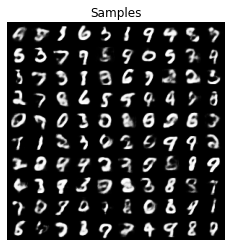

In [240]:
show_samples(samps)

In [241]:
np.sum(np.square(samps[0] - samps[2]))

88.933395